In [16]:
#Importing the main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [17]:
#Preventing any unnecessary verbose from popping up
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [18]:
!ls

Cleaned_tweets.csv  glove.6B.300d.txt  sample_data


In [19]:
#loading the dataset, from the json file stored in the given directory below, and visualising it
data = pd.read_csv("Cleaned_tweets.csv")
data.head(20)

,Unnamed: 0,Key Word,Username,User_ID,Datetime,Favorite_count,Geo,Coordinates,Label,Text,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,704,ass,DeborahParr,1.330000e+18,11-11-2020 06:56,0,NaN,NaN,1,He’d have my phone wedged up his ass sideways.,NaN,NaN,NaN
1,1915,boobies,MaxZorin85,1.330000e+18,11-11-2020 07:35,4,NaN,NaN,0,Yep 100% agree and the same with severine in s...,NaN,NaN,NaN
2,2856,eat pussy,PRISJ1_,1.330000e+18,11-11-2020 10:36,0,NaN,NaN,1,Stop having sex with men that won’t eat your p...,NaN,NaN,NaN
3,2163,Breast Man,Teresamckenzy1,1.330000e+18,10-11-2020 20:52,0,NaN,NaN,1,"When you see a sad man, just give him breast t...",NaN,NaN,NaN
4,2852,eat pussy,sj__vazquez,1.330000e+18,11-11-2020 10:42,0,NaN,NaN,1,We can't be together if you don't eat pussy,NaN,NaN,NaN
5,2040,boobies,sushiluvsyou,1.330000e+18,11-11-2020 06:08,1,NaN,NaN,1,// nsfw ( ? ) SAMATOKI BOOBIES BIG BAHONKA DON...,NaN,NaN,NaN
6,1438,big butt,alissajo17,1.330000e+18,11-11-2020 06:30,1,NaN,NaN,0,I wish I could give my bitmoji a big butt,NaN,NaN,NaN
7,257,Aroused,NikkiBogopo,1.330000e+18,10-11-2020 21:37,0,NaN,NaN,1,Is there a word for hungry and aroused like “h...,NaN,NaN,NaN
8,173,Aroused,IquantumstateI,1.330000e+18,10-11-2020 22:17,0,NaN,NaN,1,Licking your whole body until you become so ar...,NaN,NaN,NaN
9,2991,eat pussy,urcuddlybaby,1.330000e+18,11-11-2020 08:05,0,NaN,NaN,1,i think it would be lots of fun for me to eat ...,NaN,NaN,NaN


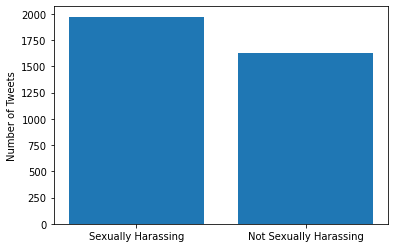

In [20]:
#Visualization
sh=0
for i in range(len(data["Label"])):
    if data["Label"].iloc[i]==1:
        sh+=1
normal=len(data["Label"])-sh
label_values={"Sexually Harassing" : sh, "Not Sexually Harassing" : normal}
plt.bar(label_values.keys(),label_values.values(),align="center")
plt.ylabel("Number of Tweets")
plt.show()

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


num_words=20000
max_sentence_len=300
tokenizer=Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(data["Text"]))
X=tokenizer.texts_to_sequences(list(data["Text"]))
X=pad_sequences(X,maxlen=max_sentence_len)
Y=to_categorical(data["Label"].values)
print("The number of unique words in the text corpus dictionary : {}".format(len(tokenizer.word_index)))
print("The shape of the trainable data : {}".format(X.shape))
print("The shape of the labels for the data is : {}".format(Y.shape))

The number of unique words in the text corpus dictionary : 8389
The shape of the trainable data : (3604, 300)
The shape of the labels for the data is : (3604, 2)


In [25]:
embedding_words={}
file=open("glove.6B.300d.txt")
for line in file:
    #There are a number of lines containing embeddings for each word
    info=line.split(" ")
    #The first value in each line of the file is a unique word
    word=info[0]
    #The rest are embedding values of a specific dimension (to be displayed)
    embedding_values=np.array(info[1:],dtype="float32")
    #Storing these values
    embedding_words[word]=embedding_values
file.close()
print("The dimension/length of the embedding vector for each word is : {}"
     .format(len(embedding_words["go"])))

The dimension/length of the embedding vector for each word is : 300


In [26]:
from keras.layers import Embedding
from keras.initializers import Constant

#The length/dimension of the embedding vector was found to be 300 after running the previous cell
embedding_dim=len(embedding_words["go"]) #or simply 300
#Initialising the embedding matrix
embedding_matrix=np.zeros((num_words,embedding_dim))
#Forming the embedding matrix by using the embedding vectors for only those words in the text corpus of the data  
for word,i in tokenizer.word_index.items():
    if i>num_words:
        continue
    embedding_vector=embedding_words.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [27]:
#Creating the embedding layer further with the help of keras
#These embeddings are made non-trainable as they are pre trained to highly optimized values
embeddings=Embedding(num_words,embedding_dim,embeddings_initializer=Constant(embedding_matrix),
                    input_length=max_sentence_len,trainable=False)
#Getting the shape of the embedding matrix (should be (num_words,embedding_dim)=(20000,300))
print("The shape of the embedding matrix is {}".format(embedding_matrix.shape))

The shape of the embedding matrix is (20000, 300)


In [28]:
#Building the model
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D 

model=Sequential()
model.add(embeddings)
model.add(Conv1D(32,3,activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Flatten())
model.add(Dense(30,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics="accuracy")

In [29]:
#Splittting the data into training and testing sets before fitting the model
#Using a 80% - 20% split for the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [30]:
batch_size=128 #Using a batch size of 128, during gradient descent
num_epochs=10 #Number of iterations/epochs over the training set

history=model.fit(x_train,y_train,batch_size=batch_size,epochs=num_epochs,validation_data=(x_test,y_test))


Epoch 1/10
23/23 [==============================] - 36s 76ms/step - loss: 0.6901 - accuracy: 0.5179 - val_loss: 0.6605 - val_accuracy: 0.6186
Epoch 2/10
23/23 [==============================] - 1s 39ms/step - loss: 0.6656 - accuracy: 0.5929 - val_loss: 0.6390 - val_accuracy: 0.6172
Epoch 3/10
23/23 [==============================] - 1s 39ms/step - loss: 0.6420 - accuracy: 0.6174 - val_loss: 0.6113 - val_accuracy: 0.6699
Epoch 4/10
23/23 [==============================] - 1s 39ms/step - loss: 0.6044 - accuracy: 0.6459 - val_loss: 0.6000 - val_accuracy: 0.6824
Epoch 5/10
23/23 [==============================] - 1s 39ms/step - loss: 0.5721 - accuracy: 0.6812 - val_loss: 0.5868 - val_accuracy: 0.6865
Epoch 6/10
23/23 [==============================] - 1s 39ms/step - loss: 0.5795 - accuracy: 0.7059 - val_loss: 0.6039 - val_accuracy: 0.6699
Epoch 7/10
23/23 [==============================] - 1s 39ms/step - loss: 0.5519 - accuracy: 0.7383 - val_loss: 0.5850 - val_accuracy: 0.6949
Epoch 8/10
2

In [31]:
test_performance=model.evaluate(x_test,y_test)
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))



23/23 [==============================] - 0s 14ms/step - loss: 0.6100 - accuracy: 0.6463
The loss of the model on the test set : 0.6099910736083984
The accuracy of the model on the test set : 64.63245749473572%


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 298, 32)           28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 32)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 149, 256)          164864    
_________________________________________________________________
flatten (Flatten)            (None, 38144)             0         
_________________________________________________________________
dense (Dense)                (None, 30)                1

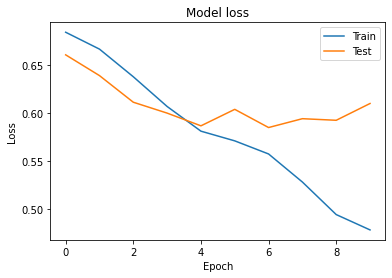

In [33]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelloss_sarcasmdetection.jpg")

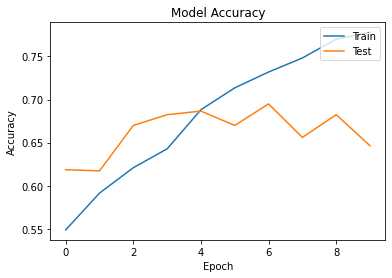

In [34]:
#Visualising the loss of the model, throughout the training process
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig("modelaccuracy_sarcasmdetection.jpg")

In [37]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred)

In [39]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='micro'))
print(f1_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average=None))

0.645815055272855
0.6461967899511514
0.6470677995677273
[0.63309353 0.65853659]


In [40]:
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='micro'))
print(recall_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average=None))

0.6452797202797202
0.6421636615811374
0.6421636615811374
[0.67692308 0.61363636]


In [41]:
from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='micro'))
print(precision_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average=None))

0.6525604551920341
0.6502808988764045
0.6582686051260399
[0.59459459 0.71052632]
